In [7]:
import calendar
import pandas as pd
import os
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import regionmask

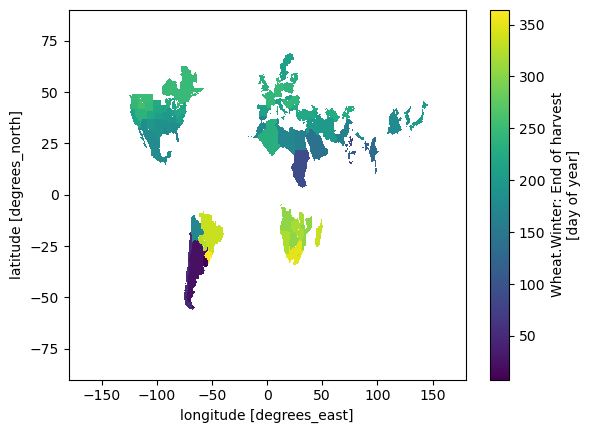

In [27]:
ds = xr.load_dataset(r"..\crop_calender\extracted\Wheat.Winter.crop.calendar.nc.gz")
ds["harvest.end"].plot()

In [67]:
import xarray as xr
import os

folder_path = r'..\crop_calender\extracted'  # Change this to your folder path
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.nc.gz')]  # Assuming NetCDF files

datasets = {}

for file_path in file_paths:
    # Load the dataset
    ds = xr.open_dataset(file_path)
    
    # Extract the first two words from the filename
    filename = os.path.basename(file_path)
    prefix = ' '.join([filename.split('.')[0], "("+filename.split('.')[1]+")"])  # Adjust the split if your delimiter isn't a dot
    # remove .crop from the prefix
    prefix = prefix.replace(' (crop)', '')

    # only keep variables plant.start, plant.end, harvest.start, harvest.end
    ds = ds[["plant.start", "plant.end", "harvest.start", "harvest.end"]]
    
    # Store the modified dataset
    datasets[prefix] = ds


datasets

{'Barley': <xarray.Dataset>
 Dimensions:        (latitude: 360, longitude: 720)
 Coordinates:
   * latitude       (latitude) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
   * longitude      (longitude) float64 -179.7 -179.2 -178.7 ... 179.3 179.8
 Data variables:
     plant.start    (latitude, longitude) float32 ...
     plant.end      (latitude, longitude) float32 ...
     harvest.start  (latitude, longitude) float32 ...
     harvest.end    (latitude, longitude) float32 ...,
 'Barley (Winter)': <xarray.Dataset>
 Dimensions:        (latitude: 360, longitude: 720)
 Coordinates:
   * latitude       (latitude) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
   * longitude      (longitude) float64 -179.7 -179.2 -178.7 ... 179.3 179.8
 Data variables:
     plant.start    (latitude, longitude) float32 ...
     plant.end      (latitude, longitude) float32 ...
     harvest.start  (latitude, longitude) float32 ...
     harvest.end    (latitude, longitude) float32 ...,
 'Cassava': <xarr

In [68]:
gdf = gpd.read_file(r"..\crop_calender\shapefiles\gaul1_asap.shp")
gdf["name"] = gdf["name1"] + ", " + gdf["name0"]

# drop rows containing "not available" in the name column
gdf = gdf[(~gdf["name"].str.contains("not available")) & (~gdf["name"].str.contains("No Name"))]

gdf

,asap1_id,name1,name1_shr,asap0_id,name0,name0_shr,km2_tot,km2_crop,km2_range,an_crop,an_range,water_lim,geometry,name
2,627,Area under National Administration,Area under NA,148,Malawi,Malawi,22353,63,9,0,0,1,"POLYGON ((34.07776 -9.52866, 34.09209 -9.54323...","Area under National Administration, Malawi"
3,2361,Lago niassa,Lago niassa,33,Mozambique,Mozambique,6882,6,7,0,0,1,"POLYGON ((34.91733 -11.89117, 34.91413 -11.891...","Lago niassa, Mozambique"
5,884,British Columbia,British Columbia,19,Canada,Canada,939564,3981,45424,1,1,0,"MULTIPOLYGON (((-130.19308 55.02708, -130.1886...","British Columbia, Canada"
6,23,Bong,Bong,160,Liberia,Liberia,8652,198,533,1,0,0,"POLYGON ((-9.30457 7.42536, -9.30018 7.42213, ...","Bong, Liberia"
7,451,The Republic of North Macedonia,North Macedonia,106,The Republic of North Macedonia,North Macedonia,25424,7244,3981,1,1,1,"POLYGON ((22.75853 41.29820, 22.76424 41.29504...","The Republic of North Macedonia, The Republic ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,10192,Kirundo,Kirundo,150,Burundi,Burundi,1774,1203,111,1,1,1,"POLYGON ((29.98240 -2.33542, 29.99806 -2.34384...","Kirundo, Burundi"
2467,10207,Gisagara,Gisagara,179,Rwanda,Rwanda,674,610,0,1,0,1,"POLYGON ((29.96762 -2.44579, 29.96576 -2.45004...","Gisagara, Rwanda"
2468,10193,Makamba,Makamba,150,Burundi,Burundi,2457,325,401,1,1,1,"POLYGON ((29.78053 -4.01365, 29.78959 -4.00936...","Makamba, Burundi"
2469,10191,Kayanza,Kayanza,150,Burundi,Burundi,1179,999,65,1,1,0,"POLYGON ((29.66566 -2.79281, 29.65976 -2.80301...","Kayanza, Burundi"


In [69]:
total_dates_df = pd.DataFrame()

for key, ds in datasets.items():
    # 1. Create mask from shapefile
    mask = regionmask.from_geopandas(gdf, 
                                    names="name", 
                                    abbrevs="_from_name").mask(ds['longitude'],
                                                                ds['latitude'])

    # 2. Aggregate variables in the xarray using the mask
    regional_agg_dr = ds.groupby(mask).mean() # max, min, mapping custom functions also work



    # 3. Convert the aggregated xarray to a dataframe
    regional_agg = regional_agg_dr.to_dataframe()
    regional_agg.reset_index(inplace=True)
    #regional_agg.dropna(inplace=True)

    # add region information and drop mask column
    regional_agg['name'] = regional_agg.apply(lambda x: gdf['name'][int(x['mask'])], axis=1)
    regional_agg = regional_agg.drop(columns=['mask'])
    # regional_agg = regional_agg.drop(columns=['crs'])



    regional_agg = regional_agg.dropna().reset_index(drop=True)
    regional_agg = regional_agg.merge(gdf, on='name')
    regional_agg['crop'] = key

    regional_agg = regional_agg[['name', 'name0', 'name1', 'crop', 'harvest.start', 'harvest.end', 'plant.start', 'plant.end', 'geometry', 'asap1_id']]

    total_dates_df = total_dates_df.append(regional_agg)

total_dates_df

,name,name0,name1,crop,harvest.start,harvest.end,plant.start,plant.end,geometry,asap1_id
0,"British Columbia, Canada",Canada,British Columbia,Barley,227.0,286.0,116.0,156.0,"MULTIPOLYGON (((-130.19308 55.02708, -130.1886...",884
1,"Zamora Chinchipe, Ecuador",Ecuador,Zamora Chinchipe,Barley,91.0,263.0,284.0,90.0,"POLYGON ((-78.34661 -3.52754, -78.34983 -3.572...",49
2,"Vaupes, Colombia",Colombia,Vaupes,Barley,162.0,263.0,10.0,141.0,"POLYGON ((-69.41947 -1.07005, -69.42337 -1.072...",86
3,"Southern Finland, Finland",Finland,Southern Finland,Barley,222.0,272.0,99.0,150.0,"POLYGON ((30.08508 61.82149, 30.06292 61.80731...",433
4,"Guainia, Colombia",Colombia,Guainia,Barley,162.0,263.0,10.0,141.0,"POLYGON ((-67.64649 3.86368, -67.64236 3.85374...",955
...,...,...,...,...,...,...,...,...,...,...
170,"Kara, Togo",Togo,Kara,Yams,182.0,31.0,32.0,90.0,"POLYGON ((1.05367 10.18244, 1.13857 10.12647, ...",1837
171,"Gôh-Djiboua, Côte d'Ivoire",Côte d'Ivoire,Gôh-Djiboua,Yams,182.0,365.0,32.0,90.0,"POLYGON ((-5.41225 6.64895, -5.41607 6.63276, ...",2216
172,"Sassandra-Marahoue, Côte d'Ivoire",Côte d'Ivoire,Sassandra-Marahoue,Yams,182.0,365.0,32.0,90.0,"POLYGON ((-5.72583 7.54439, -5.72245 7.53772, ...",2222
173,"Mamou, Guinea",Guinea,Mamou,Yams,213.0,31.0,60.0,120.0,"POLYGON ((-12.56339 11.32324, -12.55329 11.316...",2287


In [70]:
def day_to_year_dekad(day_of_year):
    """Converts a day of the year to the month and dekad it falls in."""
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    day_sum = 0
    for month, days in enumerate(days_per_month, start=1):
        for day in range(1, days + 1):
            day_sum += 1
            if day_of_year == day_sum:
                dekad_in_month = (day - 1) // 10 + 1
                if dekad_in_month > 3:  # Handle the edge case for the last day of months with 31 days
                    dekad_in_month = 3
                return month, dekad_in_month
    return 12, 3  # Default to the last dekad of December for any days beyond 365

def dekad_to_month_part(day):
    """Converts a day of the year to the month and part of the month it falls in."""
    month, dekad_in_month = day_to_year_dekad(day)
    if day > 365:
        print(f"Day {day} is not a valid day in a non-leap year.")
        return ""
    month_name = calendar.month_name[month]
    part = ['Beginning', 'Mid', 'End'][dekad_in_month - 1]
    return f"{part} of {month_name}"


In [73]:
crop_calendar = total_dates_df.copy()
crop_calendar["start_planting"] = crop_calendar["plant.start"].apply(lambda x: dekad_to_month_part(x))
crop_calendar["start_harvest"] = crop_calendar["harvest.start"].apply(lambda x: dekad_to_month_part(x))
crop_calendar["end_planting"] = crop_calendar["plant.end"].apply(lambda x: dekad_to_month_part(x))
crop_calendar["end_harvest"] = crop_calendar["harvest.end"].apply(lambda x: dekad_to_month_part(x))

crop_calendar

,name,name0,name1,crop,harvest.start,harvest.end,plant.start,plant.end,geometry,asap1_id,start_planting,start_harvest,end_planting,end_harvest
0,"British Columbia, Canada",Canada,British Columbia,Barley,227.0,286.0,116.0,156.0,"MULTIPOLYGON (((-130.19308 55.02708, -130.1886...",884,End of April,Mid of August,Beginning of June,Mid of October
1,"Zamora Chinchipe, Ecuador",Ecuador,Zamora Chinchipe,Barley,91.0,263.0,284.0,90.0,"POLYGON ((-78.34661 -3.52754, -78.34983 -3.572...",49,Mid of October,Beginning of April,End of March,Mid of September
2,"Vaupes, Colombia",Colombia,Vaupes,Barley,162.0,263.0,10.0,141.0,"POLYGON ((-69.41947 -1.07005, -69.42337 -1.072...",86,Beginning of January,Mid of June,End of May,Mid of September
3,"Southern Finland, Finland",Finland,Southern Finland,Barley,222.0,272.0,99.0,150.0,"POLYGON ((30.08508 61.82149, 30.06292 61.80731...",433,Beginning of April,Beginning of August,End of May,End of September
4,"Guainia, Colombia",Colombia,Guainia,Barley,162.0,263.0,10.0,141.0,"POLYGON ((-67.64649 3.86368, -67.64236 3.85374...",955,Beginning of January,Mid of June,End of May,Mid of September
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,"Kara, Togo",Togo,Kara,Yams,182.0,31.0,32.0,90.0,"POLYGON ((1.05367 10.18244, 1.13857 10.12647, ...",1837,Beginning of February,Beginning of July,End of March,End of January
171,"Gôh-Djiboua, Côte d'Ivoire",Côte d'Ivoire,Gôh-Djiboua,Yams,182.0,365.0,32.0,90.0,"POLYGON ((-5.41225 6.64895, -5.41607 6.63276, ...",2216,Beginning of February,Beginning of July,End of March,End of December
172,"Sassandra-Marahoue, Côte d'Ivoire",Côte d'Ivoire,Sassandra-Marahoue,Yams,182.0,365.0,32.0,90.0,"POLYGON ((-5.72583 7.54439, -5.72245 7.53772, ...",2222,Beginning of February,Beginning of July,End of March,End of December
173,"Mamou, Guinea",Guinea,Mamou,Yams,213.0,31.0,60.0,120.0,"POLYGON ((-12.56339 11.32324, -12.55329 11.316...",2287,Beginning of March,Beginning of August,End of April,End of January


In [74]:
crop_calendar["question"] = crop_calendar.apply(lambda x: f"""When does planting and harvesting of {x['crop']} in {x['name']} usually start and end? 
When there are several season for a crop, provide the values clearly seperated for all seasons. E.g when the question is about Maize season A, also provide the values for Maize season B.
Reply with the month and part of the month ("Beginning of", "Mid of", "End of") for planting and harvesting. E.g. "Mid of May" for planting start and "End of June" for planting end.
Reply with EXACTLY 4 values: planting start: <part><month>, planting end: <part><month>, harvesting start: <part><month>, harvesting end: <part><month>.
Answer precisely for {x['crop']} in {x['name']}!""",
axis=1)  

crop_calendar["answer"] = crop_calendar.apply(lambda x: f"""planting start: {x['start_planting']},
planting end: {x['end_planting']},
harvesting start: {x['start_harvest']},
harvesting end: {x['end_harvest']}""",
axis=1)   

crop_calendar.to_csv(r'..\temp_data\crop_calendar_questions.csv', index=False, sep=';')

In [75]:
crop_calendar

,name,name0,name1,crop,harvest.start,harvest.end,plant.start,plant.end,geometry,asap1_id,start_planting,start_harvest,end_planting,end_harvest,question,answer
0,"British Columbia, Canada",Canada,British Columbia,Barley,227.0,286.0,116.0,156.0,"MULTIPOLYGON (((-130.19308 55.02708, -130.1886...",884,End of April,Mid of August,Beginning of June,Mid of October,When does planting and harvesting of Barley in...,"planting start: End of April,\nplanting end: B..."
1,"Zamora Chinchipe, Ecuador",Ecuador,Zamora Chinchipe,Barley,91.0,263.0,284.0,90.0,"POLYGON ((-78.34661 -3.52754, -78.34983 -3.572...",49,Mid of October,Beginning of April,End of March,Mid of September,When does planting and harvesting of Barley in...,"planting start: Mid of October,\nplanting end:..."
2,"Vaupes, Colombia",Colombia,Vaupes,Barley,162.0,263.0,10.0,141.0,"POLYGON ((-69.41947 -1.07005, -69.42337 -1.072...",86,Beginning of January,Mid of June,End of May,Mid of September,When does planting and harvesting of Barley in...,"planting start: Beginning of January,\nplantin..."
3,"Southern Finland, Finland",Finland,Southern Finland,Barley,222.0,272.0,99.0,150.0,"POLYGON ((30.08508 61.82149, 30.06292 61.80731...",433,Beginning of April,Beginning of August,End of May,End of September,When does planting and harvesting of Barley in...,"planting start: Beginning of April,\nplanting ..."
4,"Guainia, Colombia",Colombia,Guainia,Barley,162.0,263.0,10.0,141.0,"POLYGON ((-67.64649 3.86368, -67.64236 3.85374...",955,Beginning of January,Mid of June,End of May,Mid of September,When does planting and harvesting of Barley in...,"planting start: Beginning of January,\nplantin..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,"Kara, Togo",Togo,Kara,Yams,182.0,31.0,32.0,90.0,"POLYGON ((1.05367 10.18244, 1.13857 10.12647, ...",1837,Beginning of February,Beginning of July,End of March,End of January,When does planting and harvesting of Yams in K...,"planting start: Beginning of February,\nplanti..."
171,"Gôh-Djiboua, Côte d'Ivoire",Côte d'Ivoire,Gôh-Djiboua,Yams,182.0,365.0,32.0,90.0,"POLYGON ((-5.41225 6.64895, -5.41607 6.63276, ...",2216,Beginning of February,Beginning of July,End of March,End of December,When does planting and harvesting of Yams in G...,"planting start: Beginning of February,\nplanti..."
172,"Sassandra-Marahoue, Côte d'Ivoire",Côte d'Ivoire,Sassandra-Marahoue,Yams,182.0,365.0,32.0,90.0,"POLYGON ((-5.72583 7.54439, -5.72245 7.53772, ...",2222,Beginning of February,Beginning of July,End of March,End of December,When does planting and harvesting of Yams in S...,"planting start: Beginning of February,\nplanti..."
173,"Mamou, Guinea",Guinea,Mamou,Yams,213.0,31.0,60.0,120.0,"POLYGON ((-12.56339 11.32324, -12.55329 11.316...",2287,Beginning of March,Beginning of August,End of April,End of January,When does planting and harvesting of Yams in M...,"planting start: Beginning of March,\nplanting ..."
